# Introduction

This notebook provides a very brief summary, examples, and R-coding demos as additional material for the course on numerical optimization I designed and lectured in summer term 2019 at the LMU Munich. A draft of the lecture notes can be found in `./notes/numopt_lecture.pdf`. The focus of the course is on solving continuous optimization problems. For further reading on the topic I recommend the book "Numerical Optimization" by Nocedal and Wright.

In [3]:
# required libraries
library("grid")     # for visualization
library("lattice")  # for visualization

# functions
source("./src/viz_functions.R")
source("./src/objectives.R")

# Unconstrained Optimization

The focus of unconstrained continuous optimization is on solving the optimization problem $$\min\limits_{x \in \mathbb{R}^{n}} f(x),$$ where $f:\mathbb{R}^{n} \rightarrow \mathbb{R}$ is continously differentiable.

## Line Search Method

A neccessary (but not sufficient) condition for $x^{*} \in \mathbb{R}^{n}$ to be a solution is $\nabla f(x^{*}) = 0$, i.e. $x^{*}$ is a *stationary point* of $f$. In general, there is no analytical solution to this non-linear equation such that numerical methods have to be applied in order to find stationary points. *Descent methods* generate a sequence $(x^{(k)})_{k \in \mathbb{N}_0}$ with $$f(x^{(k+1)}) < f(x^{(k)}) \ \ \forall k \in \mathbb{N}_0.$$ In this context, *line search methods* choose a *descent direction* $d^{(k)} \in \mathbb{R}^{n}$ and a *step length* $t_k > 0$ and use the update $$x^{(k+1)} \leftarrow x^{(k)} + t_k d^{(k)}.$$ Adequate descent directions are for example:
- $d^{(k)} = - \nabla f(x^{(k)})$
- $d^{(k)} = -A \nabla f(x^{(k)})$, where $A$ is symmetric positive definite

For the step length $t_k > 0$ the challenge is in avoiding both, a too small and a too large step. In practice, this is for example achieved by the *backtracking* approach that finds a step length that meets the *Wolfe conditions* (or the *Armijo condition*).

In [4]:
# backtracking line search (with default values) and descent direction check
backtracking <- function(f, gradf, x, d, tmax = 1, c = 0.01, rho = 0.5) {
  t <- tmax
  a <- f(x)               # intercept of linear function
  v <- gradf(x) %*% d
  if (v >= 0) stop("d is not a descent direction")
  b <- c * v              # slope of linear function
  while (f(x + t*d) > a + b*t) {
    t <- rho*t
  }
  return(t)
}

## Steepest Descent Method

The direction $- \nabla f(x)$ is not only a descent direction, but it is the *steepest descent direction* of $f$ at $x$. Using this descent direction yields the *steepest descent method*. Its popularity is based on the fact that it is a very simple method that guarantees global convergence. That means that for an arbitrary starting point, the method converges to a stationary point (and not that the method converges to a global solution).

In [5]:
# steepest descent method with backtracking line search
steepest_descent = function(f, gradf, x, t = NA, tol = 1e-10){
  n_iter <- 0                     # iteration counter
  iterates <- list(x)             # save iterates (for visualization)
  linesearch <- is.na(t)          # check if constant step size or linesearch
  while (sqrt(sum(gradf(x)^2)) > tol) {      # check stopping criterion
    d <- -gradf(x)                           # steepest descent direction
    if (linesearch) {
      t <- backtracking(f, gradf, x, d)      # backtracking line search
    }
    x <- x + t*d                             # steepest descent step
    n_iter <- n_iter+1
    iterates[[n_iter+1]] <- x
  }
  result <- list()
  result$results <- list("solution" = x,        # solution vector
                         "opt_value" = f(x),    # optimal value
                         "n_iter" = n_iter)     # number of iterations
  result$iterates <- iterates                   # all iterates (visualization)
  return(result)
}

As an example, the minimization of the *Himmelblau function* $$f_{himmel} : \mathbb{R}^2 \rightarrow \mathbb{R}, \ \ x \mapsto (x_1^2 + x_2 - 11)^2 + (x_1 + x_2^2 - 7)^2$$ is shown below with starting point $x^{(0)} = (-2, 0)^T$. The function has four minima, all with optimal value zero. The steepest descent finds one solution after $23$ iterations.

solution = (-2.805118, 3.131313) 
optimal value = 0.000000 
number of iterations = 23

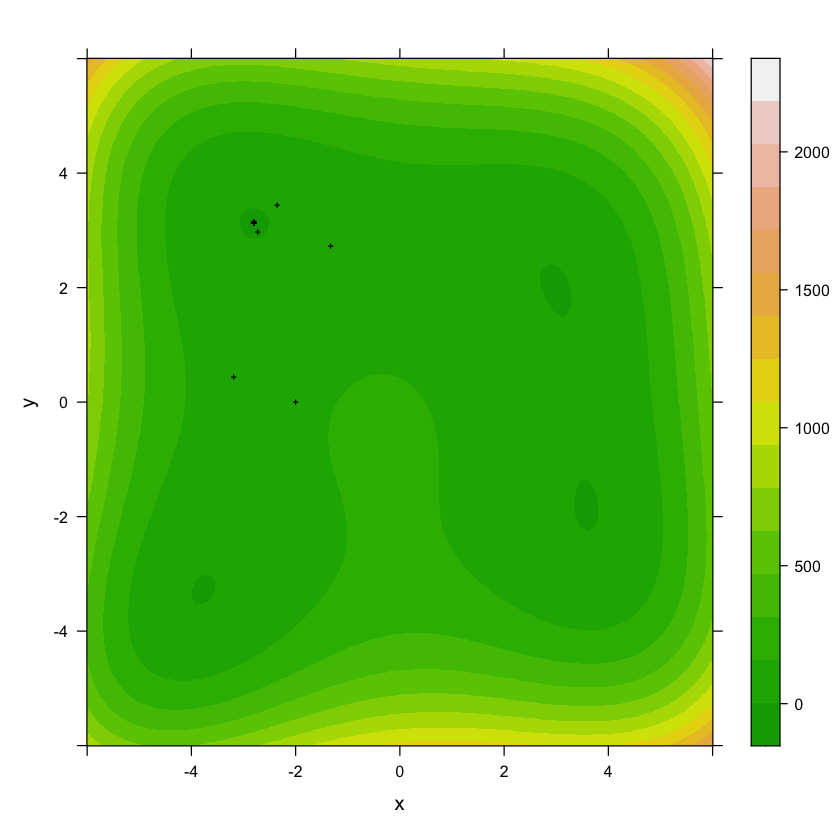

In [5]:
# steepest descent for Himmelblau function
x_start <- c(-2, 0)
sd_min <- steepest_descent(f_himmel, grad_himmel, x = x_start)
cat(sprintf("solution = (%f, %f) \n", sd_min$results$solution[1], sd_min$results$solution[2]))
cat(sprintf("optimal value = %f \n", sd_min$results$opt_value))
cat(sprintf("number of iterations = %s", sd_min$results$n_iter))
plot_iterates_2d(f_himmel, sd_min$iterates, xlim=c(-6, 6), ylim=c(-6, 6))

Changing the starting point to $x^{(0)} = (-2, -2)^T$ shows, that, depending on the starting point, the method converges to another solution, but that the number of iterations does not change much.

solution = (-3.779310, -3.283186) 
optimal value = 0.000000 
number of iterations = 24

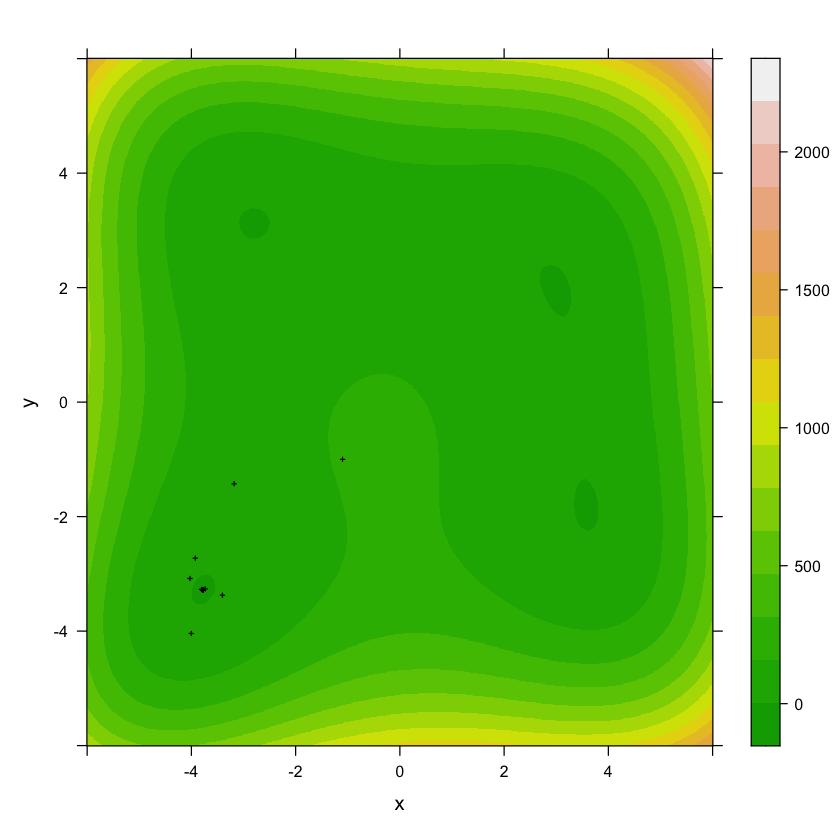

In [6]:
# steepest descent for Himmelblau function
x_start <- c(-1.1, -1)
sd_min <- steepest_descent(f_himmel, grad_himmel, x = x_start)
cat(sprintf("solution = (%f, %f) \n", sd_min$results$solution[1], sd_min$results$solution[2]))
cat(sprintf("optimal value = %f \n", sd_min$results$opt_value))
cat(sprintf("number of iterations = %s", sd_min$results$n_iter))
plot_iterates_2d(f_himmel, sd_min$iterates, xlim=c(-6, 6), ylim=c(-6, 6))

Even though the steepest descent method converges globally, it is unfortunately not very efficient and actually becomes very slow for many problems since the convergence rate is only linear: $$f(x^{(k+1)}) - f(x^{*}) \leq \left(\dfrac{\kappa(\nabla^2 f(x^*))-1}{\kappa(\nabla^2 f(x^*))+1} \right)^2 (f(x^{(k)}) - f(x^{*})),$$ where $\kappa$ denotes the condition number. That means, if $\kappa(\nabla^2 f(x^*)) >> 1$, the method becomes extremly slow. This is shown by the minimization of the *Rosenbrock function* $$f_{rosen}: \mathbb{R}^2 \rightarrow \mathbb{R}, \ \ x \mapsto 100(x_2−x_1^2)^2+(1−x_1)^2,$$ which has a strict unique minimizer at $x^* = (1,1)^T$ with optimal value $f_{rosen}(x^*) = 0$. The steepest descent method finds the solution as expected, but requires approximately $25,000$ iterations, which is ridiculously large. Note that $\kappa(\nabla^2 f_{rosen}(x^*)) \approx 2,500$.

solution = (1.000000, 1.000000) 
optimal value = 0.000000 
number of iterations = 24906

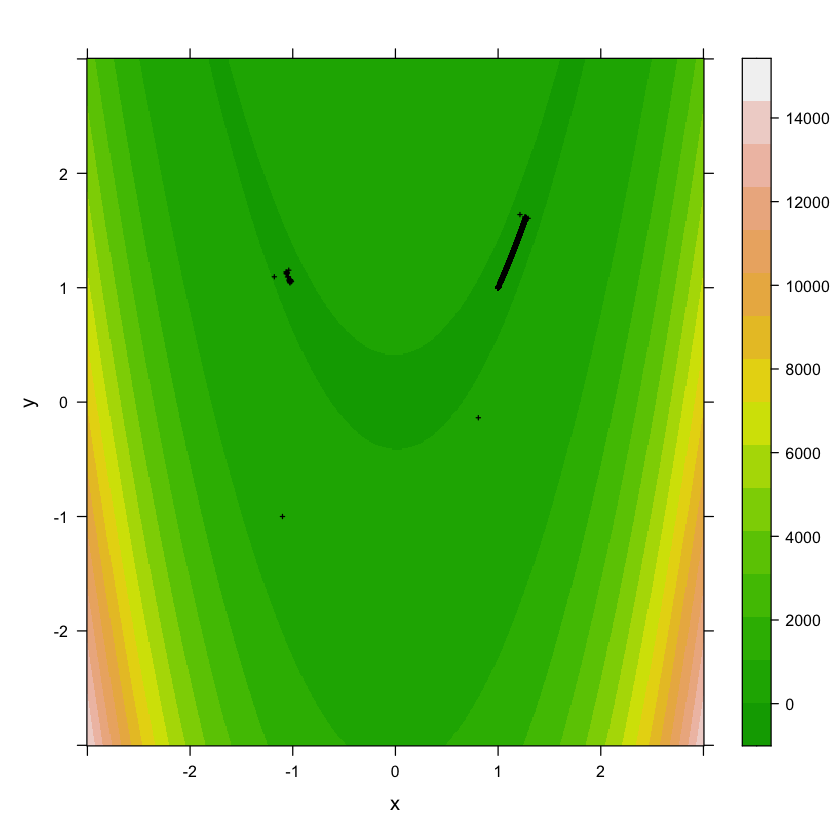

In [7]:
# steepest descent for Rosenbrock function
x_start <- c(-1.1, -1)
sd_min <- steepest_descent(f_rosen, grad_rosen, x = x_start)
cat(sprintf("solution = (%f, %f) \n", sd_min$results$solution[1], sd_min$results$solution[2]))
cat(sprintf("optimal value = %f \n", sd_min$results$opt_value))
cat(sprintf("number of iterations = %s", sd_min$results$n_iter))
plot_iterates_2d(f_rosen, sd_min$iterates, xlim=c(-3, 3), ylim=c(-3, 3))

## Newton Method

The steepest descent method only makes use of first order information, that is gradient information. If $f$ is twice continuously differentiable, the Taylor expansion yields $$\nabla f(x + h) \approx \nabla f(x) + \nabla^2 f(x)h$$ such that $$\nabla f(x + h) \approx 0 \ \iff \ h = -\nabla^2 f(x)^{-1}\nabla f(x),$$ provided $\nabla^2 f(x)$ is non-singular. This leads to the *Newton method*, where the descent direction $d^{(k)}$ is given by the solution of the *Newton equation* $$\nabla^2 f(x^{(k)})d^{(k)} = \nabla f(x^{(k)}).$$ It is important to note, that the Newton direction is obtained by (efficiently) solving a linear system and not (!) by inverting a matrix. Further, using the Newton direction provides a natural step length of $t_k = 1$.

In [7]:
# Newton method
newton = function(f, gradf, hessf, x, tol = 1e-10){
  n_iter <- 0                     # iteration counter
  iterates <- list(x)             # save iterates (for visualization)
  while (sqrt(sum(gradf(x)^2)) > tol) {   # check stopping criterion
    d <- solve(hessf(x), -gradf(x))       # Newton-direction via Newton system
    x <- x + d                    # Newton step with step length 1
    n_iter <- n_iter+1
    iterates[[n_iter+1]] <- x
  }
  result <- list()
  result$results <- list("solution" = x,        # solution vector
                         "opt_value" = f(x),    # optimal value
                         "n_iter" = n_iter)     # number of iterations
  result$iterates <- iterates                   # all iterates (visualization)
  return(result)
}

As an example, the Rosenbrock function is minimized with starting point $x^{(0)} = (-1, -1)^T$. The Newton method finds the solution within two iterations. What a tremendous improvemend compared to the $25,000$ iterations of the steepest descent method.

solution = (1.000000, 1.000000) 
optimal value = 0.000000 
number of iterations = 2

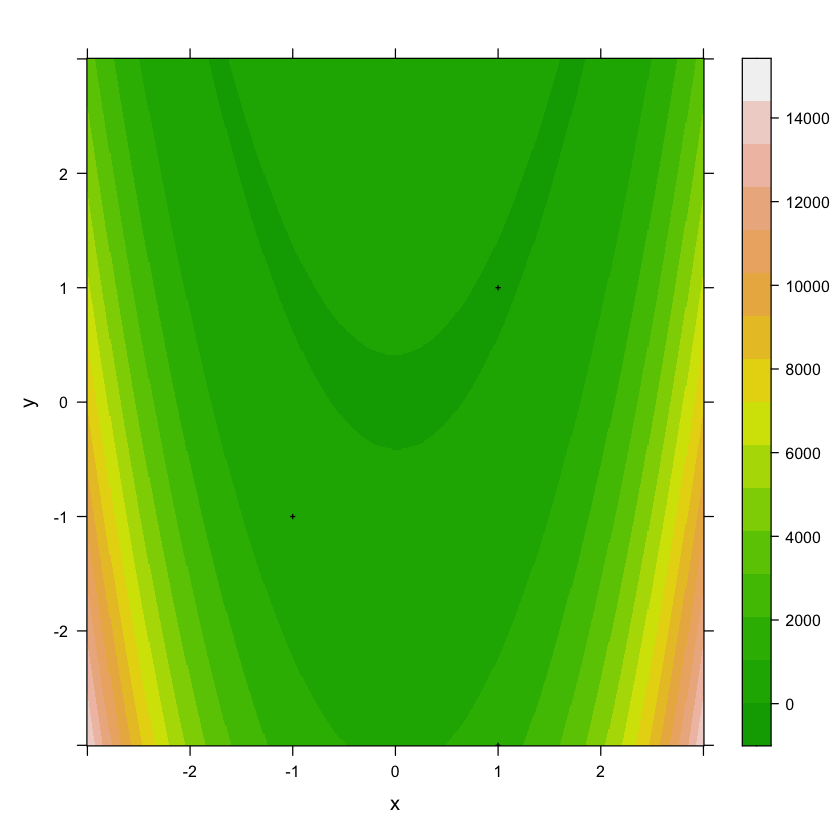

In [9]:
# Newton method for Rosenbrock function
x_start <- c(-1, -1)
newton_min <- newton(f_rosen, grad_rosen, hess_rosen, x = x_start)
cat(sprintf("solution = (%f, %f) \n", newton_min$results$solution[1], sd_min$results$solution[2]))
cat(sprintf("optimal value = %f \n", newton_min$results$opt_value))
cat(sprintf("number of iterations = %s", newton_min$results$n_iter))
plot_iterates_2d(f_rosen, newton_min$iterates, xlim=c(-3, 3), ylim=c(-3, 3))

The Newton method is very fast. More precisely, its convergence rate is (locally) quadratic for most problems and at least (locally) superlinear. This comes, of course, at a price. Each iteration is computationally much more expensive compared to the steepest descent method, especially if the problem dimension $n$ is large, since in every iteration the Hessian $\nabla^2f(x^{(k)}) \in \mathbb{R}^{n \times n}$ has to be computed and a linear system has to be solved. There are some approaches to deal with this problem while maintaining a fast convergence rate:
- Simplified Newton method: $\nabla^2f(x^{(k)})$ is replaced with $\nabla^2f(x^{(0)})$ and updated every $j$ iterations.
- Inexact Newton method: the Newton equation is not solved exactly but only approximately by using, for example, very few steps of the CG-method.
- Finite difference Newton method: the derivatives $\nabla f$ and $\nabla^2f$are not computed explicitely but approximated by finite difference methods.

A problem with the Newton method is, that it finds a stationary point very fast, but there is no guarantee that this is a minimum of $f$, but a maximum. This is because, if $\nabla^2f(x^{(k)})$ is not positive definite, the Newton direction is not a descent direction. Convergence to a maximum is shown by applying the Newton method to the Himmelblau function with starting point $x^{(0)} = (-1.1, -1)^T$.

In [8]:
# Newton method for Himmelblau function
x_start <- c(-1.1, -1)
newton_min <- newton(f_himmel, grad_himmel, hess_himmel, x = x_start)
cat(sprintf("solution = (%f, %f) \n", newton_min$results$solution[1], sd_min$results$solution[2]))
cat(sprintf("optimal value = %f \n", newton_min$results$opt_value))
cat(sprintf("number of iterations = %s", newton_min$results$n_iter))
plot_iterates_2d(f_himmel, newton_min$iterates, xlim=c(-6, 6), ylim=c(-6, 6))

ERROR: Error in newton(f_himmel, grad_himmel, hess_himmel, x = x_start): konnte Funktion "newton" nicht finden


In order to prevent the Newton method to converge to a maximum of $f$, the fixed step length can be replaced by a line-search strategy that ensures $f(x^{(k+1)}) < f(x^{(k)})$. In order to maintain the fast convergence rate of the Newton method a backtracking line-search with $t_{max} = 1$ and stopping criterion $ -\nabla f(x^{(k)})^{T} d^{(k)} < 0$ is used, leading to the *damped Newton method*.

In [12]:
# damped Newton method
newton_damped = function(f, gradf, hessf, x, tol = 1e-10){
  n_iter <- 0                     # iteration counter
  iterates <- list(x)             # save iterates (for visualization)
  while (sqrt(sum(gradf(x)^2)) > tol) {   # check stopping criterion
    d <- solve(hessf(x), -gradf(x))       # Newton-direction via Newton system
    t <- backtracking(f, gradf, x, d)     # backtracking line search
    x <- x + t*d              # Newton step
    n_iter <- n_iter+1
    iterates[[n_iter+1]] <- x
  }
  result <- list()
  result$results <- list("solution" = x,        # solution vector
                         "opt_value" = f(x),    # optimal value
                         "n_iter" = n_iter)     # number of iterations
  result$iterates <- iterates                   # all iterates (visualization)
  return(result)
}

Using the damped Newton method does (of course) not always find the optimal step length, as shown by the minimization of the Rosenbrock function, leading to an increased number of iterations compared to the undamped Newton method. However, it is still much more efficient than the steepest descent method. Further, it prevents convergence to a maximum as shown by the application to the Himmelblau function.

solution = (1.000000, 1.000000) 
optimal value = 0.000000 
number of iterations = 134

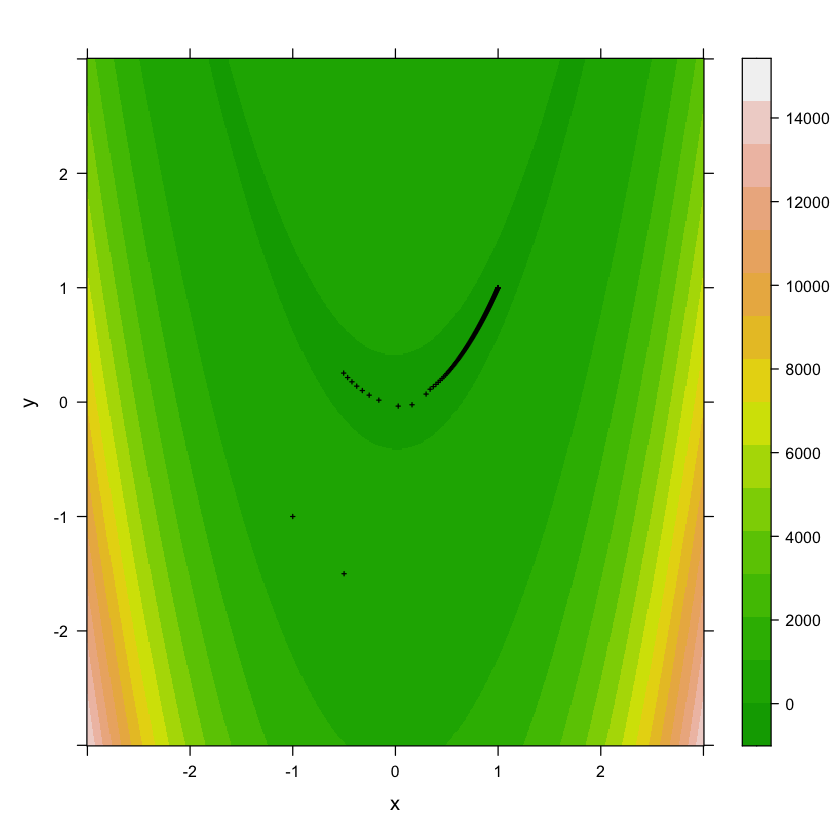

In [13]:
# damped Newton method for Rosenbrock function
x_start <- c(-1, -1)
newton_min <- newton_damped(f_rosen, grad_rosen, hess_rosen, x = x_start)
cat(sprintf("solution = (%f, %f) \n", newton_min$results$solution[1], sd_min$results$solution[2]))
cat(sprintf("optimal value = %f \n", newton_min$results$opt_value))
cat(sprintf("number of iterations = %s", newton_min$results$n_iter))
plot_iterates_2d(f_rosen, newton_min$iterates, xlim=c(-3, 3), ylim=c(-3, 3))

In [9]:
# damped Newton method for Himmelblau function
x_start <- c(-1.1, -1)
newton_min <- newton_damped(f_himmel, grad_himmel, hess_himmel, x = x_start)

ERROR: Error in newton_damped(f_himmel, grad_himmel, hess_himmel, x = x_start): konnte Funktion "newton_damped" nicht finden


The Newton method is locally convergent, which is due to the fact that "close" to a solution $-\nabla^2 f(x^{(k)})^{(-1)}$ is positive definite, such that the Newton direction is a descent direction. However, "far away" from a solution, that has not to be the case. One idea is combine the Newton method with a globally convergent method, such as the steepest descent method, i.e. to start with the steepest descent method and to switch to the Newton method after some (many) steepest descent iterations. However, this comes along with a slow overall convergence rate. But some very popular alternatives exists, such as quasi-Newton methods and trust-region Newton methods.

## Quasi-Newton Method

The success of the Newton method is based on the use of second order information, i.e. Hessians. In practice, computing the Hessian and solving the Newton system can be very difficult and expensive. Quasi-Newton methods generate a series of Hessian approximations without computing the Hessians while, at the same time, maintain a fast rate of convergence. The basic idea is to find a matrix $B_k \approx \nabla^2 f(x^{(k)})$ in some sense and, in analogy to the (damped) Newton method, to update $$x^{(k+1)} \leftarrow x^{(k)} − t_k B_k^{-1} \nabla f(x^{(k)}).$$ Again, note that the matrices $B_k$ are not inverted, but that a linear system has to be solved. For the matrix $B_k$ it is requiered, that:
- $B_k \approx \nabla^2 f(x^{(k)})$ to maintain fast convergence
- $B_k$ is positive definite, such that $d^{(k)}$ is a descent direction
- $B_k$ is of simple structure, such that the linear can be efficiently solved
- $B_{k+1}$ can be updated from $B_k$, i.e. $B_{k+1} = B_k + U_k$, where $U_k$ is of simple structure


One of the most efficient quasi-Newton methods is the *BFGS method*, where $$B_{k+1}^{BFGS} = B_k + \dfrac{y^{(k)}(y^{(k)})^T}{(y^{(k)})^Ts^{(k)}} - \dfrac{B_ks^{(k)}(B_ks^{(k)})^T}{(s^{(k)})^TB_ks^{(k)}},$$ where $s^{(k)} = x^{(k+1)} - x^{(k)}$ and $y^{(k)} = \nabla f(x^{(k+1)}) - \nabla f(x^{(k)})$. Thus, updating the Hessian approximation is not very expensive (most expensive part is $B_ks^{(k)}$).

Exploiting the special structure of the BFGS-update, it is possible to directly obtain an approximation to the inverse Hessian $H_k := B_k^{-1}$, which is computationally much more convenient (matrix-vector product instead of solving a linear system). The *inverse BFGS-update* is given as $$H_{k+1}^{BFGS} = H_{k}^{BFGS} - \dfrac{1}{(y^{(k)})^Ts^{(k)}} \left( s^{(k)}(y^{(k)})^T H_k + H_k y^{(k)}(s^{(k)})^T \right) + \dfrac{1}{((y^{(k)})^Ts^{(k)})^2} \left( s^{(k)})^Ty^{(k)} + (y^{(k)})^TH_ky^{(k)} \right) s^{(k)}(s^{(k)})^T.$$
Again, the most expensive part of the inverse BFGS-update is a matrix-vector product.

In [10]:
# inverse BFGS-update
inverse_bfgs_update = function(gradf, x, x_new, H){
  s <- x_new - x
  y <- gradf(x_new) - gradf(x)
  rho <- as.numeric(1/crossprod(s,y))
  v <- H %*% y
  U <- -rho*(tcrossprod(s,v) + tcrossprod(v,s)) +
    as.numeric(rho^2*(1/rho + crossprod(y,v)))*tcrossprod(s,s)
  return(H + U)
}

In [11]:
# quasi-Newton method with inverse BFGS-update
quasi_newton_bfgs = function(f, gradf, x, tol = 1e-10){
  n_iter <- 0                     # iteration counter
  iterates <- list(x)             # save iterates (for visualization)
  H <- diag(length(x))            # initial inverse Hessian approximation
  while (sqrt(sum(gradf(x)^2)) > tol) {     # check stopping criterion
    d <- as.vector(-H %*% gradf(x))                    # quasi-Newton direction
    t <- backtracking(f, gradf, x, d)    # backtracking line search
    x_new <- x + t*d                            # compute new iterate
    H <- inverse_bfgs_update(gradf, x, x_new, H)   # inverse BFGS-update
    x <- x_new                                  # update iterate
    n_iter <- n_iter+1
    iterates[[n_iter+1]] <- x
  }
  result <- list()
  result$results <- list("solution" = x,        # solution vector
                         "opt_value" = f(x),    # optimal value
                         "n_iter" = n_iter)     # number of iterations
  result$iterates <- iterates                   # all iterates (visualization)
  return(result)
}

The quasi-Newton method (with inverse BFGS-update) is as (un)complex as the steepest descent methos, since it requieres only first order information (gradients) and martix-vector products. However, its performance is much better with a superlinear convergence rate. Further it is not as fast as the Newton method (quadratic convergence), but it is therfore globally convergent. Both aspects are shown in the examples below.

solution = (1.000000, 1.000000) 
optimal value = 0.000000 
number of iterations = 26

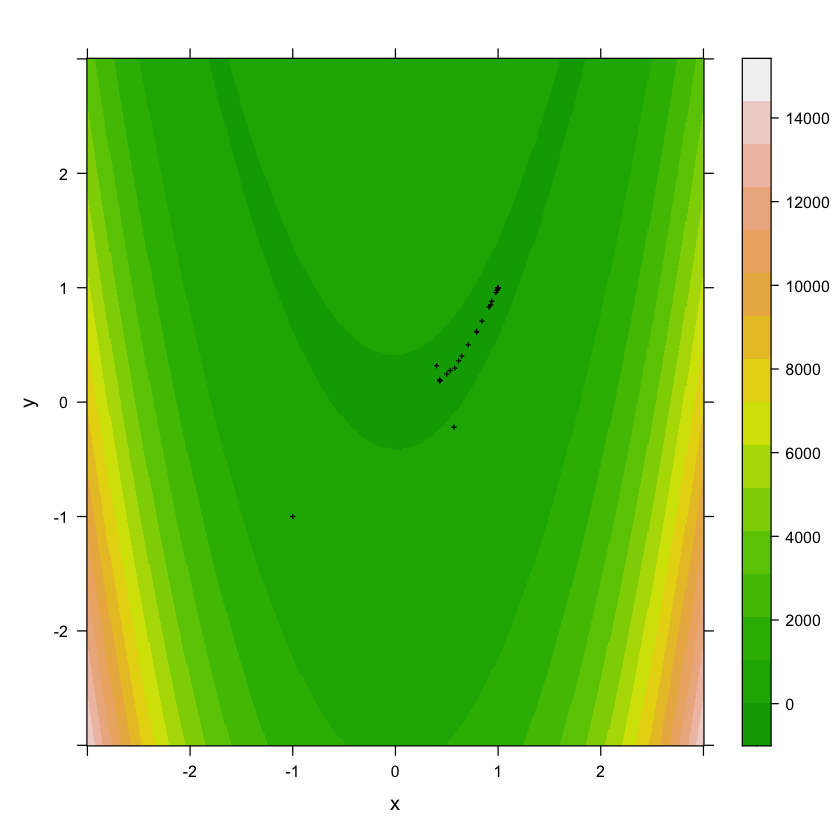

In [23]:
# quasi-Newton-BFGS method for Rosenbrock function
x_start <- c(-1, -1)
bfgs_min <- quasi_newton_bfgs(f_rosen, grad_rosen, x = x_start)
cat(sprintf("solution = (%f, %f) \n", bfgs_min$results$solution[1], sd_min$results$solution[2]))
cat(sprintf("optimal value = %f \n", bfgs_min$results$opt_value))
cat(sprintf("number of iterations = %s", bfgs_min$results$n_iter))
plot_iterates_2d(f_rosen, bfgs_min$iterates, xlim=c(-3, 3), ylim=c(-3, 3))

solution = (-3.779310, 1.000000) 
optimal value = 0.000000 
number of iterations = 13

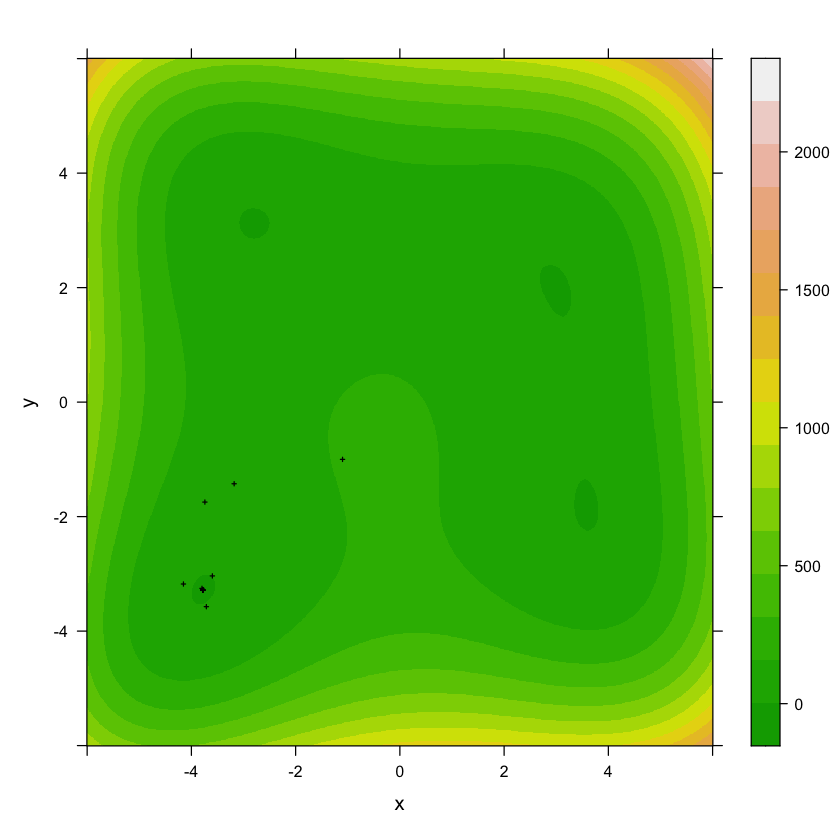

In [12]:
# quasi-Newton-BFGS method for Himmelblau function
x_start <- c(-1.1, -1)
bfgs_min <- quasi_newton_bfgs(f_himmel, grad_himmel, x = x_start)
cat(sprintf("solution = (%f, %f) \n", bfgs_min$results$solution[1], sd_min$results$solution[2]))
cat(sprintf("optimal value = %f \n", bfgs_min$results$opt_value))
cat(sprintf("number of iterations = %s", bfgs_min$results$n_iter))
plot_iterates_2d(f_himmel, bfgs_min$iterates, xlim=c(-6, 6), ylim=c(-6, 6))